In [111]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

In [112]:

#To achieve the desired output, we need to:
#
#1. Load the JSON data.
#
#2. Create an empty DataFrame to store the final result.
#
#3. Iterate over the 'data' list in the JSON data. For each dictionary in the 'data' list:
#   - Extract the 'code' value.
#   - Iterate over the 'history' list. For each dictionary in the 'history' list:
#     - Extract the 'start' and 'interval' values.
#     - Convert the 'start' value to a datetime.
#     - Add the 'interval' value to the 'start' datetime to get the 'end' datetime.
#     - Create a new row in the DataFrame with the 'end' datetime, the 'code' value, and the 'data' value.
#4. Pivot the DataFrame to move the 'code' values into columns.


# Load the data
with open('../data/VIC1.json') as f:
    data = json.load(f)

# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over the 'data' list
for d in data['data']:

    start = datetime.fromisoformat(d['history']['start'].replace("Z", "+00:00"))
    # interval is a string like "5m" or "30s" or "1d"
    # add the interval to the start time to get the end time
    interval = int(d['history']['interval'][:-1])
    interval_unit = d['history']['interval'][-1]
    if interval_unit != "m":
        raise ValueError("interval unit '" + interval_unit + "' not supported")
    time = start
    # Iterate over the 'history' data list
    for h in d['history']['data']:
        time = time + timedelta(minutes=int(d['history']['interval'][:-1]))
        row = {'id': d['id'], 'network':d['network'], 'region':d['region'], 'type':d['type'], 'code': d['code'], 'time': time, 'data': h}
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df.head(6)

,id,network,region,type,code,time,data
0,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:05:00+10:00,2995.0
1,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:10:00+10:00,3101.0
2,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:15:00+10:00,3070.0
3,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:20:00+10:00,3169.0
4,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:25:00+10:00,3113.0
5,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:30:00+10:00,3172.0


In [113]:
# Pivot the DataFrame
df_pivot = df.pivot(index='time', columns='id', values='data')
df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_30min.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power']
# Interpolate 'NaN' values in 'solar_rooftop' data 30 min intervals to 6 five-minute intervals
df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_30min.power'].interpolate() / 6
# Smooth out the 'solar_rooftop' data over six five-minute intervals
# df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_smooth.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power'].rolling(window=6).mean()
# show rows of wind power and price
df_pivot[['au.nem.vic1.fuel_tech.solar_utility.power', 'au.nem.vic1.fuel_tech.solar_rooftop.power', 'au.nem.vic1.fuel_tech.solar_rooftop_30min.power', 'au.nem.vic1.fuel_tech.wind.power', 'au.nem.vic1.price']].tail(10)

id,au.nem.vic1.fuel_tech.solar_utility.power,au.nem.vic1.fuel_tech.solar_rooftop.power,au.nem.vic1.fuel_tech.solar_rooftop_30min.power,au.nem.vic1.fuel_tech.wind.power,au.nem.vic1.price
time,,,,,
2024-01-13 10:20:00+10:00,610.9,204.444444,NaN,1235.0,-45.00
2024-01-13 10:25:00+10:00,666.8,206.888889,NaN,1232.0,-42.93
2024-01-13 10:30:00+10:00,649.8,209.333333,1256.0,1286.0,-42.93
2024-01-13 10:35:00+10:00,646.9,212.472222,NaN,1308.0,-42.35
2024-01-13 10:40:00+10:00,615.4,215.611111,NaN,1378.0,-38.07
2024-01-13 10:45:00+10:00,573.6,218.750000,NaN,1417.0,-34.30
2024-01-13 10:50:00+10:00,529.6,221.888889,NaN,1547.0,-44.70
2024-01-13 10:55:00+10:00,548.7,225.027778,NaN,1466.0,-47.02
2024-01-13 11:00:00+10:00,537.8,228.166667,1369.0,1474.0,-42.93


In [114]:
# Load the fueltech data
# Source: https://api.opennem.org.au/fueltechs
with open('../data/fueltech.json') as f:
    fueltech = json.load(f)
renewables = [item['code'] for item in fueltech if item['renewable']]

<Axes: xlabel='time'>

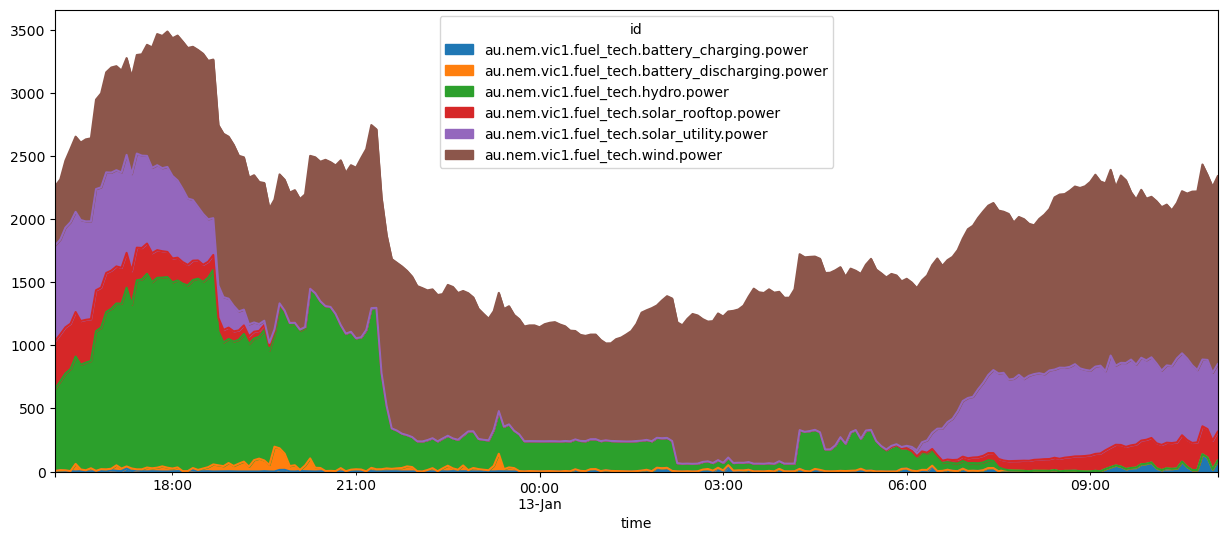

In [115]:
renewable_fuel_tech_columns = [col for col in df_pivot.columns if any('.'+tech+'.' in col for tech in renewables)]
df_renewables = df_pivot[renewable_fuel_tech_columns]

# Plot all data
# df_renewables.plot.area(figsize=(15, 6))

# Get the current time and make it timezone-aware
now = datetime.now().replace(tzinfo=pytz.UTC)

# Convert to the desired timezone
now = now.astimezone(pytz.timezone('Australia/Melbourne'))

# Calculate the time 24 hours ago
one_day_ago = now - timedelta(days=1)

# Filter the DataFrame to include only rows where 'time' is within the last 24 hours
df_last_24_hours = df_renewables[df_renewables.index > one_day_ago]

# Plot the data
df_last_24_hours.plot.area(figsize=(15, 6))

